## Extracting motion from videos

In [ ]:
import subprocess
import os

folders = os.listdir("demo/CONDUCTOR_DATA/Conductor_video_data/qi/")

for folder in folders:
    folder = folder.split(".")[0]
    os.makedirs("demo/results/"+folder, exist_ok=True)
    command = f'scripts/inference.sh smplest_x_h CONDUCTOR_DATA/Conductor_video_data/qi/{folder}.mp4 30'

    subprocess.run(command, shell=True)

## Audio extraction

In [ ]:
import os
import subprocess

for author_name in os.listdir("demo/CONDUCTOR_DATA/Conductor_video_data/"):
    for i in os.listdir("demo/CONDUCTOR_DATA/Conductor_video_data/"+author_name+"/"):
        subprocess.run([
        "ffmpeg", "-i", "demo/CONDUCTOR_DATA/Conductor_video_data/"+author_name+"/"+i, 
        "-q:a", "0", "-map", "a", 
        "demo/CONDUCTOR_DATA/Conductor_audio_data/"+author_name+"/"+i.split(".mp4")[0]+".mp3"
    ])

## Aligning audio to video frame

In [4]:
import numpy as np

def align_audio_to_video_fps(audio_feat, sr, hop_length, fps, n_frames, mode="linear"):

    T_a, D = audio_feat.shape
    t_a = (np.arange(T_a) * hop_length) / float(sr)
    t_v = (np.arange(n_frames) + 0.5) / float(fps)
    t_v_clamped = np.clip(t_v, t_a[0], t_a[-1])

    if mode == "nearest":
        idx = np.searchsorted(t_a, t_v_clamped, side="left")
        idx = np.clip(idx, 0, T_a-1)
        out = audio_feat[idx]
    else:
        out = np.empty((n_frames, D), dtype=audio_feat.dtype)
        if mode == "linear":
            for d in range(D):
                out[:, d] = np.interp(t_v_clamped, t_a, audio_feat[:, d])
        elif mode == "cubic":
            try:
                from scipy.interpolate import CubicSpline
                for d in range(D):
                    cs = CubicSpline(t_a, audio_feat[:, d], bc_type="natural", extrapolate=False)
                    out[:, d] = cs(t_v_clamped)
                nan_mask = ~np.isfinite(out)
                if nan_mask.any():
                    out[nan_mask] = np.take_along_axis(out, np.clip(np.argmax(~nan_mask, axis=0), 0, n_frames-1)[None,:], axis=0)
            except Exception:
                for d in range(D):
                    out[:, d] = np.interp(t_v_clamped, t_a, audio_feat[:, d])
        else:
            raise ValueError("mode must be 'nearest' | 'linear' | 'cubic'")
    return out

import numpy as np
import librosa

def _ensure_time_first(S_db):
    S_db = np.asarray(S_db, float)
    if S_db.ndim != 2:
        raise ValueError("S_db must be 2D (T,M) or (M,T).")
    T, M = S_db.shape
    if T < M:  # May be (M,T)
        return S_db.T
    return S_db

def _norm01(x, p_lo=1, p_hi=99):
    x = np.asarray(x, float)
    lo, hi = np.percentile(x, p_lo), np.percentile(x, p_hi)
    if hi - lo < 1e-8:
        return np.zeros_like(x)
    return np.clip((x - lo) / (hi - lo), 0, 1)

def midlevel_from_mel_db_follow_frames(
    S_db,
    low_mel_bins=5,
    with_frame_beat_grid=True,
    beat_sigma_frames=1.0,
    sr=None,
    hop_length=None,
):
    S_db = _ensure_time_first(S_db)         # (T,M)
    T, M = S_db.shape
    S_lin = 10 ** (S_db / 10.0)             # (T,M)

    # 1) Spectral flux
    d_db = np.diff(S_db, axis=0)
    flux = np.maximum(d_db, 0.0).sum(axis=1)
    flux = np.concatenate([[0.0], flux])        # (T,)
    flux = _norm01(flux).reshape(-1, 1)         # (T,1)

    # 2) Onset envelope
    onset = np.abs(d_db).mean(axis=1)
    onset = np.concatenate([[0.0], onset])      # (T,)
    if T >= 5:
        k = 5
        onset = np.convolve(onset, np.ones(k)/k, mode='same')
    onset = _norm01(onset).reshape(-1, 1)       # (T,1)

    # 3) RMS
    rms = np.sqrt(np.maximum(S_lin.sum(axis=1), 0.0))
    rms = _norm01(rms).reshape(-1, 1)           # (T,1)

    # 4) Low-band energy
    k_low = int(np.clip(low_mel_bins, 1, M))
    lowband = S_lin[:, :k_low].sum(axis=1)
    lowband = _norm01(lowband).reshape(-1, 1)   # (T,1)

    # 5) Novelty
    d1 = np.diff(S_db, axis=0, prepend=S_db[[0], :])
    d2 = np.diff(d1, axis=0, prepend=d1[[0], :])
    novelty = np.abs(d2).mean(axis=1)
    if T >= 9:
        k2 = 9
        novelty = np.convolve(novelty, np.ones(k2)/k2, mode='same')
    novelty = _norm01(novelty).reshape(-1, 1)   # (T,1)

    parts = {
        "onset": onset,        # (T,1)
        "flux": flux,          # (T,1)
        "rms": rms,            # (T,1)
        "lowband": lowband,    # (T,1)
        "novelty": novelty,    # (T,1)
    }

    if with_frame_beat_grid:
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(onset[:, 0], distance=max(1, int(round(beat_sigma_frames*2))), prominence=0.1)
        grid_bin = np.zeros(T, dtype=float); grid_bin[peaks] = 1.0
        xs = np.arange(T)
        grid_soft = np.zeros(T, dtype=float)
        for i in peaks:
            grid_soft += np.exp(-0.5 * ((xs - i) / beat_sigma_frames) ** 2)
        grid_soft = grid_soft / (grid_soft.max() + 1e-8)

        parts["beat_grid_bin"]  = grid_bin.reshape(-1, 1)  # (T,1)
        parts["beat_grid_soft"] = grid_soft.reshape(-1, 1) # (T,1)

    if sr is not None and hop_length is not None:
        try:
            tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset[:, 0], sr=sr, hop_length=hop_length)
            parts["tempo_bpm"] = float(tempo)
            parts["beat_frames_librosa"] = beat_frames  # [0..T-1]
        except Exception:
            pass

    # Concatenate
    order = ["onset", "flux", "rms", "lowband", "novelty"]
    if with_frame_beat_grid:
        order += ["beat_grid_bin", "beat_grid_soft"]
    feats = np.concatenate([parts[k] for k in order if k in parts], axis=1)  # (T, D)

    return feats, parts

import numpy as np
import librosa

def _safe_norm01(x, eps=1e-8):
    x = np.asarray(x, float)
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps: return np.zeros_like(x)
    return (x - mn) / (mx - mn + eps)

def _build_soft_grid(frame_times, event_times, sigma_sec=0.04):
    if len(event_times) == 0:
        return np.zeros_like(frame_times)
    d = np.min(np.abs(frame_times[:,None] - event_times[None,:]), axis=1)
    g = np.exp(-0.5 * (d / max(sigma_sec,1e-6))**2)
    return _safe_norm01(g)

def _frame_times_from_target(n_frames, duration_sec):
    return np.linspace(0.0, duration_sec, n_frames, endpoint=False)

def _infer_uniform_beats(duration_sec, bpm):
    if bpm <= 0: return np.array([])
    period = 60.0 / bpm
    n = int(np.floor(duration_sec / period)) + 1
    return np.arange(n) * period

def _phase_from_beats(frame_times, beat_times):
    T = len(frame_times)
    phi = np.zeros(T, dtype=float)
    if len(beat_times) < 2:
        return phi 
    idx = np.searchsorted(beat_times, frame_times, side='right') - 1
    idx = np.clip(idx, 0, len(beat_times)-2)
    b0 = beat_times[idx]
    b1 = beat_times[idx+1]
    phi = (frame_times - b0) / np.maximum(b1 - b0, 1e-6)
    return np.clip(phi, 0.0, 1.0)

def add_time_sync_phase_features(
    sr, hop_length,
    S_db=None,          
    y=None,              
    n_frames=None,       
    fps=30,              
    meter=4,            
    use_harmonics=True,  
    bpm_hint=None,       
    soft_sigma_sec=0.04 
):
   
    assert n_frames is not None, "n_frames should align with mel_to_video"

    if S_db is not None:
        S_for_onset = S_db.T 
        onset_env = librosa.onset.onset_strength(S=S_for_onset, sr=sr, hop_length=hop_length)
    elif y is not None:
        onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    else:
        raise ValueError("Please give S_db or y")

    duration_audio = (len(onset_env)-1) * hop_length / float(sr) if len(onset_env) > 1 else 0.0

    tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length)

    if len(beat_times) < 2:
        if bpm_hint is None or bpm_hint <= 0:
            cand = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, hop_length=hop_length, aggregate=None)
            bpm_use = float(cand[0]) if cand is not None and len(cand)>0 else 120.0
        else:
            bpm_use = float(bpm_hint)
        beat_times = _infer_uniform_beats(duration_audio, bpm_use)

    duration_target = n_frames / float(fps)
    frame_times = _frame_times_from_target(n_frames, duration_target)

    if duration_audio > 0 and abs(duration_audio - duration_target) / max(duration_target,1e-6) > 0.01:
        scale = duration_target / duration_audio
        beat_times = beat_times * scale

    # 3) Phase（ϕ）
    phi = _phase_from_beats(frame_times, beat_times)  # (n_frames,)

    # 4) Embedded
    feats_list = []
    sin1 = np.sin(2*np.pi*phi); cos1 = np.cos(2*np.pi*phi)
    feats_list += [sin1[:,None], cos1[:,None]]
    if use_harmonics:
        sin2 = np.sin(4*np.pi*phi); cos2 = np.cos(4*np.pi*phi)
        feats_list += [sin2[:,None], cos2[:,None]]

    # 5) bar phase）
    bar_sin = bar_cos = None
    if meter is not None and meter >= 2 and len(beat_times) >= 2:
        idx = np.searchsorted(beat_times, frame_times, side='right') - 1
        idx = np.clip(idx, 0, max(0, len(beat_times)-2))
        beat_index = idx 
        bar_phi = ((beat_index % meter) + phi) / float(meter)
        bar_sin = np.sin(2*np.pi*bar_phi); bar_cos = np.cos(2*np.pi*bar_phi)
        feats_list += [bar_sin[:,None], bar_cos[:,None]]

    beat_grid_soft = _build_soft_grid(frame_times, beat_times, sigma_sec=soft_sigma_sec)
    beat_grid_bin  = np.zeros(n_frames, dtype=float)
    if len(beat_times) > 0:

        idx_near = np.clip(np.round(beat_times * fps).astype(int), 0, n_frames-1)
        beat_grid_bin[idx_near] = 1.0
    feats_list += [beat_grid_soft[:,None], beat_grid_bin[:,None]]

    feats_phase = np.concatenate(feats_list, axis=1)

    parts = {
        "phi": phi,                              # (n_frames,)
        "beat_times_sec": beat_times,            # (n_beats,)
        "frame_times_sec": frame_times,          # (n_frames,)
        "beat_grid_soft": beat_grid_soft,        # (n_frames,)
        "beat_grid_bin": beat_grid_bin,          # (n_frames,)
        "bar_phase": (bar_sin, bar_cos) if bar_sin is not None else None,
        "tempo_bpm_est": float(tempo) if np.isfinite(tempo) else None,
    }
    return feats_phase, parts


In [ ]:
import numpy as np
import librosa

import cv2, os

for author_name in os.listdir("demo/CONDUCTOR_DATA/Conductor_video_data/"):
    for video_name in os.listdir("demo/CONDUCTOR_DATA/Conductor_video_data/"+author_name+"/"):

        file_name = video_name.split(".")[0]
        
        #if(file_name+".npy" not in os.listdir("demo/CONDUCTOR_DATA/Mel_sequence/"+author_name)):
        if(1<2):

            video_path = "demo/CONDUCTOR_DATA/Conductor_video_data/"+author_name+"/"+file_name+".mp4" 
            video_path = os.path.abspath(video_path)

            cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

            if not cap.isOpened():
                cap = cv2.VideoCapture(video_path)

            assert cap.isOpened(), f"Cannot open：{video_path}."

            fps = cap.get(cv2.CAP_PROP_FPS)
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #print("fps =", fps, "frames =", n_frames)

            audio_path="demo/CONDUCTOR_DATA/Conductor_audio_data/"+author_name+"/"+file_name+".mp3"

            y, sr = librosa.load(audio_path, sr=None, mono=True)
            hop_length = round(sr / 30)       
            n_fft = 2048                          
            win_length = n_fft                   

            # 3) Compute Feature
            S = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                win_length=win_length, center=False, n_mels=64, power=2.0
            )  # Shape：(n_mels, n_audio_frames)
            S_db = librosa.power_to_db(S, ref=np.max).T
            
            beat_feats, parts = midlevel_from_mel_db_follow_frames(S_db, low_mel_bins=5, with_frame_beat_grid=True)
            phase_feats, parts = add_time_sync_phase_features(
                                    sr=sr, hop_length=hop_length,
                                    S_db=S_db,            
                                    n_frames=len(S_db),    
                                    fps=30,               
                                    meter=4,              
                                    use_harmonics=True,
                                    bpm_hint=None,        
                                    soft_sigma_sec=0.04  
                                )
            feats = np.concatenate([beat_feats,phase_feats],axis=-1)
            
            n_frames = int(np.load("demo/CONDUCTOR_DATA/Frame_num/"+author_name+"/"+file_name+".npy"))
            
            mel_to_video = align_audio_to_video_fps(S_db, sr, hop_length, 30, n_frames, mode="linear")
            beat_to_video = align_audio_to_video_fps(feats, sr, hop_length, 30, n_frames, mode="linear")
            
            
            eff_frame = len(os.listdir("demo/results/"+author_name+"/"+file_name))
            if(eff_frame!=0):
                print("fps =", fps, "frames =", n_frames, "Effective frames =", eff_frame)
                final_mel_feature = mel_to_video[:eff_frame]
                final_beat_feature = beat_to_video[:eff_frame]
                np.save("demo/CONDUCTOR_DATA/Mel_sequence/"+author_name+"/"+file_name+".npy",final_mel_feature)
                np.save("demo/CONDUCTOR_DATA/Beat_feature/"+author_name+"/"+file_name+".npy",final_beat_feature)

## Dividing Mel seqence into clips

In [6]:
import numpy as np

def split_motion_sequence(seq, window=120, step=60):

    frames = seq.shape[0]
    segments = []

    for start in range(0, frames - window + 1, step):
        end = start + window
        segment = seq[start:end]  # (120, 22, 3)
        segments.append(segment)

    return np.array(segments)

In [7]:
for author_name in os.listdir("demo/CONDUCTOR_DATA/Mel_sequence/"):
    for motion_clip_name in os.listdir("demo/CONDUCTOR_DATA/Mel_sequence/"+author_name):
        motion_clip = np.load("demo/CONDUCTOR_DATA/Mel_sequence/"+author_name+"/"+motion_clip_name)
        if(motion_clip.shape[0]>=120):
            segments = split_motion_sequence(motion_clip, window=120, step=60)
        for i in range(len(segments)):
            np.save("demo/CONDUCTOR_DATA/Mel_Clips/"+author_name+"/"+motion_clip_name.split(".")[0]+"_"+str(i+1)+".npy", segments[i])

In [8]:
for author_name in os.listdir("demo/CONDUCTOR_DATA/Beat_feature/"):
    for motion_clip_name in os.listdir("demo/CONDUCTOR_DATA/Beat_feature/"+author_name):
        motion_clip = np.load("demo/CONDUCTOR_DATA/Beat_feature/"+author_name+"/"+motion_clip_name)
        if(motion_clip.shape[0]>=120):
            segments = split_motion_sequence(motion_clip, window=120, step=60)
        for i in range(len(segments)):
            np.save("demo/CONDUCTOR_DATA/Beat_Clips/"+author_name+"/"+motion_clip_name.split(".")[0]+"_"+str(i+1)+".npy", segments[i])

## Visualizing Mel-Spectrogram

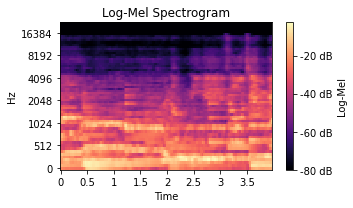

In [9]:
import matplotlib.pyplot as plt

S_db=np.load("demo/CONDUCTOR_DATA/Mel_Clips/liu/3_8.npy")

hop_length = round(sr / 30)         
n_fft = 2048                      
win_length = n_fft                  

plt.figure(figsize=(5, 3))
img = librosa.display.specshow(
    S_db[:120].T, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='mel')

plt.colorbar(img, format='%+2.0f dB', label='Log-Mel')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()

## Converting extracted motion into SMPL format

In [ ]:
count = 0
for author_name in os.listdir("demo/results"):
    author_name="qi"
    for motion_clip in os.listdir("demo/results/"+author_name):
        frame_num = len(os.listdir("demo/results/"+author_name+"/"+motion_clip))
        frame_list=[]
        print("demo/CONDUCTOR_DATA/Motion_data/"+author_name+"/"+motion_clip+".npy")
        for i in range(frame_num):
            extracted_motion = np.load("demo/results/"+author_name+"/"+motion_clip+"/"+str(i+1)+".npy")
            for i in range(1):
                smpl_motion_list=[]
                smpl_motion_list.append(extracted_motion[i][0][:])#0
                smpl_motion_list.append(extracted_motion[i][2][:])#1
                smpl_motion_list.append(extracted_motion[i][1][:])#2
                smpl_motion_list.append((((extracted_motion[i][0][:]+extracted_motion[i][7][:])/2)+extracted_motion[i][0][:])/2)#3
                smpl_motion_list.append(extracted_motion[i][4][:])#4
                smpl_motion_list.append(extracted_motion[i][3][:])#5
                smpl_motion_list.append((extracted_motion[i][0][:]+extracted_motion[i][7][:])/2)#6
                smpl_motion_list.append(extracted_motion[i][6][:])#7
                smpl_motion_list.append(extracted_motion[i][5][:])#8
                smpl_motion_list.append((extracted_motion[i][0][:]+extracted_motion[i][7][:])/2)#9
                smpl_motion_list.append((extracted_motion[i][17][:]+extracted_motion[i][18][:])/2)#10
                smpl_motion_list.append((extracted_motion[i][14][:]+extracted_motion[i][15][:])/2)#11
                smpl_motion_list.append(extracted_motion[i][7][:])#12
                smpl_motion_list.append((((extracted_motion[i][0][:]+extracted_motion[i][7][:])/2)+extracted_motion[i][9][:])/2)#13
                smpl_motion_list.append((((extracted_motion[i][0][:]+extracted_motion[i][7][:])/2)+extracted_motion[i][8][:])/2)#14
                smpl_motion_list.append(extracted_motion[i][21][:])#15
                smpl_motion_list.append(extracted_motion[i][9][:])#16
                smpl_motion_list.append(extracted_motion[i][8][:])#17
                smpl_motion_list.append(extracted_motion[i][11][:])#18
                smpl_motion_list.append(extracted_motion[i][10][:])#19
                smpl_motion_list.append(extracted_motion[i][13][:])#20
                smpl_motion_list.append(extracted_motion[i][12][:])#21
                smpl_frame = np.array(smpl_motion_list)
                
            frame_list.append(smpl_frame)    
            smpl_motion_sequence = np.array(frame_list)
            smpl_motion_sequence[:, :, [1, 2]] = smpl_motion_sequence[:, :, [2, 1]]
            smpl_motion_sequence = smpl_motion_sequence*np.array([1,1,-1])
            
        np.save("demo/CONDUCTOR_DATA/Motion_data/"+author_name+"/"+motion_clip+".npy",smpl_motion_sequence)

## Dividing motion seqence into clips

In [11]:
import numpy as np

def split_motion_sequence(seq, window=120, step=60):

    frames = seq.shape[0]
    segments = []

    for start in range(0, frames - window + 1, step):
        end = start + window
        segment = seq[start:end]  # (120, 22, 3)
        segments.append(segment)

    return np.array(segments)

In [12]:
for author_name in os.listdir("demo/CONDUCTOR_DATA/Motion_data/"):
    for motion_clip_name in os.listdir("demo/CONDUCTOR_DATA/Motion_data/"+author_name):
        motion_clip = np.load("demo/CONDUCTOR_DATA/Motion_data/"+author_name+"/"+motion_clip_name)
        if(motion_clip.shape[0]>=120):
            segments = split_motion_sequence(motion_clip, window=120, step=60)
        for i in range(len(segments)):
            np.save("demo/CONDUCTOR_DATA/Motion_Clips/"+author_name+"/"+motion_clip_name.split(".")[0]+"_"+str(i+1)+".npy", segments[i])

## Creating Dataset array

In [13]:
motion_feature_list=[]
audio_feature_list=[]
beat_feature_list=[]
for author_name in os.listdir("demo/CONDUCTOR_DATA/6D_motion/"):
    for motion_clip_name in os.listdir("demo/CONDUCTOR_DATA/6D_motion/"+author_name+"/train"):
        motion_clip = np.load("demo/CONDUCTOR_DATA/6D_motion/"+author_name+"/train/"+motion_clip_name)
        audio_clip = np.load("demo/CONDUCTOR_DATA/Mel_Clips/"+author_name+"/"+motion_clip_name.split("_p0")[0]+".npy")
        Beat_clip = np.load("demo/CONDUCTOR_DATA/Beat_Clips/"+author_name+"/"+motion_clip_name.split("_p0")[0]+".npy")
        replacement = np.array([1, 0, 0, 0, 1, 0])
        mask = np.isnan(motion_clip).any(axis=-1)   # shape = (19742, 120, 23)
        motion_clip[mask] = replacement
        motion_feature_list.append(motion_clip)
        audio_feature_list.append(audio_clip)
        beat_feature_list.append(Beat_clip)
Motion_feature_array = np.array(motion_feature_list)
Audio_feature_array = np.array(audio_feature_list)
Beat_feature_array = np.array(beat_feature_list)

motion_mean = np.mean(Motion_feature_array.reshape(-1,23,6),0)
motion_std = np.std(Motion_feature_array.reshape(-1,23,6),0)
np.save("demo/CONDUCTOR_DATA/Motion_Mean.npy",motion_mean)
np.save("demo/CONDUCTOR_DATA/Motion_Std.npy",motion_std)

audio_mean = np.mean(Audio_feature_array.reshape(-1,64),0)
audio_std = np.std(Audio_feature_array.reshape(-1,64),0)
np.save("demo/CONDUCTOR_DATA/Audio_Mean.npy",audio_mean)
np.save("demo/CONDUCTOR_DATA/Audio_Std.npy",audio_std)

beat_mean = np.mean(Beat_feature_array.reshape(-1,15),0)
beat_std = np.std(Beat_feature_array.reshape(-1,15),0)
np.save("demo/CONDUCTOR_DATA/Beat_Mean.npy",beat_mean)
np.save("demo/CONDUCTOR_DATA/Beat_Std.npy",beat_std)

Motion_feature_array_norm = (Motion_feature_array - motion_mean)/(motion_std+0.000000001)
np.save("demo/CONDUCTOR_DATA/Motion_feature.npy",Motion_feature_array_norm)

Audio_feature_array_norm = (Audio_feature_array - audio_mean)/(audio_std+0.000000001)
np.save("demo/CONDUCTOR_DATA/Audio_feature.npy",Audio_feature_array_norm)

Beat_feature_array_norm = (Beat_feature_array - beat_mean)/(beat_std+0.000000001)
np.save("demo/CONDUCTOR_DATA/Beat_feature.npy",Beat_feature_array)